In [13]:
import sys
sys.path.insert(1, '/home/yannik/vssil')

import matplotlib.pyplot as plt
import pylab
import torch
import numpy as np
from torch.nn import KLDivLoss
from torchvision.io import read_video
from scipy.special import kl_div

from src.utils.kpt_utils import get_image_patches, kpts_2_img_coordinates
from contrastive_loss_test_data.test_data import load_sample_images
from contrastive_loss_test_data.test_keypoints import get_perfect_keypoints, get_bad_keypoints, get_random_keypoints

In [14]:
torch.manual_seed(123)

sample_size = 4
batch_size = 16

img_tensor = load_sample_images(sample_size=sample_size,
                                path="/home/yannik/vssil/contrastive_loss_test_data/990000.mp4").unsqueeze(0)
img_tensor = img_tensor.repeat((batch_size, 1, 1, 1, 1))
N, T, C, H, W = img_tensor.shape

time_window = 5
patch_size = (9, 9)

pos_range = max(int(time_window / 2), 1) if time_window > 1 else 0
center_index = int(patch_size[0] / 2)

step_matrix = torch.ones(patch_size + (2,))

step_w = 2 / W
step_h = 2 / H

for k in range(0, patch_size[0]):
    for l in range(0, patch_size[1]):
        step_matrix[k, l, 0] = (l - center_index) * step_w
        step_matrix[k, l, 1] = (k - center_index) * step_h
        
n_bins = 100
hist_norm_p = float('inf')
v_min = 0
v_max = 1.0

Read key-point data and extract image patches

In [15]:
perfect_kpt_coordinates = get_perfect_keypoints(T=sample_size).unsqueeze(0)
perfect_kpt_coordinates = perfect_kpt_coordinates.repeat((batch_size, 1, 1, 1))
_, _, K, D = perfect_kpt_coordinates.shape

perfect_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=perfect_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))

N, T, K, C, Hp, Wp  = perfect_kpt_patches.shape

In [16]:
bad_kpt_coordinates = get_bad_keypoints(T=sample_size).unsqueeze(0)
bad_kpt_coordinates = bad_kpt_coordinates.repeat((batch_size, 1, 1, 1))

bad_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=bad_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))

In [17]:
random_kpt_coordinates = get_random_keypoints(T=sample_size).unsqueeze(0)
random_kpt_coordinates = random_kpt_coordinates.repeat((batch_size, 1, 1, 1))

random_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=random_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))

Apply Sobel filter to obtain gradients

In [18]:
from kornia.filters import sobel

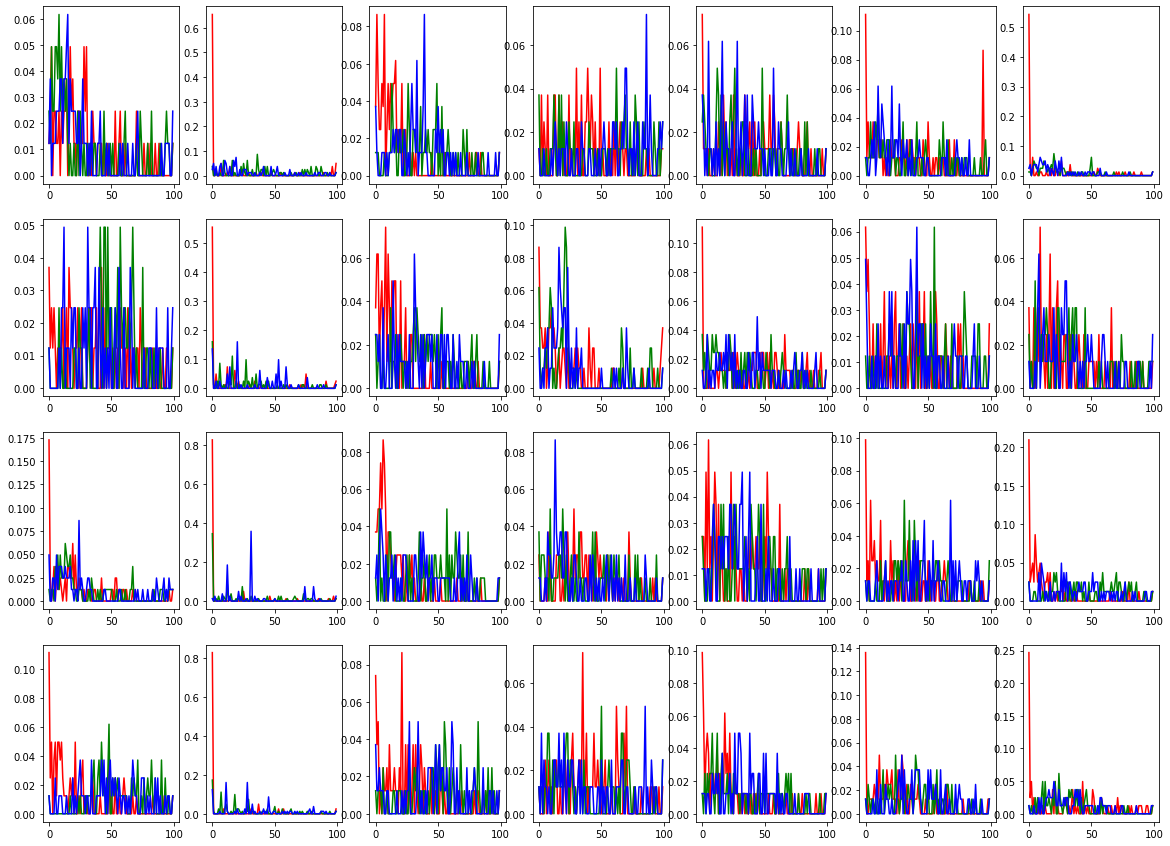

In [19]:
perfect_mag = sobel(perfect_kpt_patches.view((N*T*K, C, Hp, Wp))).view((N, T, K, C, Hp, Wp))

perfect_mag_hists = torch.empty((N, T, K, C, n_bins))

for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                perfect_mag_hists[n, t, k, c] = torch.histc(perfect_mag[n, t, k, c], bins=n_bins)
                # Normalize to prob. distribution
                perfect_mag_hists[n, t, k, c] /= torch.sum(perfect_mag_hists[n, t, k, c], dim=-1)
                
fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), perfect_mag_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), perfect_mag_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), perfect_mag_hists[0, t, k, 2], color='blue')

tensor([[0.0494, 0.1605, 0.0864, 0.0988, 0.0617, 0.0864, 0.5062],
        [0.1358, 0.3580, 0.0741, 0.0988, 0.0864, 0.0617, 0.1728],
        [0.0617, 0.3580, 0.0741, 0.0617, 0.0741, 0.0617, 0.0864]])
tensor(0.1340)


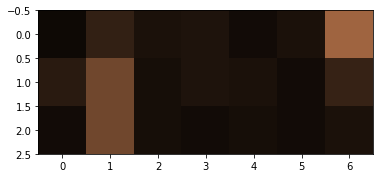

In [20]:
perfect_mag_dist = torch.empty((K, T-1))

for k in range(K):
    for t in range(T-1):
        #perfect_dist[k, t] = dkl(perfect_hists[0, t:t+1, k, :], perfect_hists[0, t+1:t+2, k, :])
        perfect_mag_dist[k, t] = torch.norm(perfect_mag_hists[0, t:t+1, k, :] - perfect_mag_hists[0, t+1:t+2, k, :], p=hist_norm_p)

print(perfect_mag_dist.T)
        
plt.imshow(perfect_mag_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(perfect_mag_dist.mean())

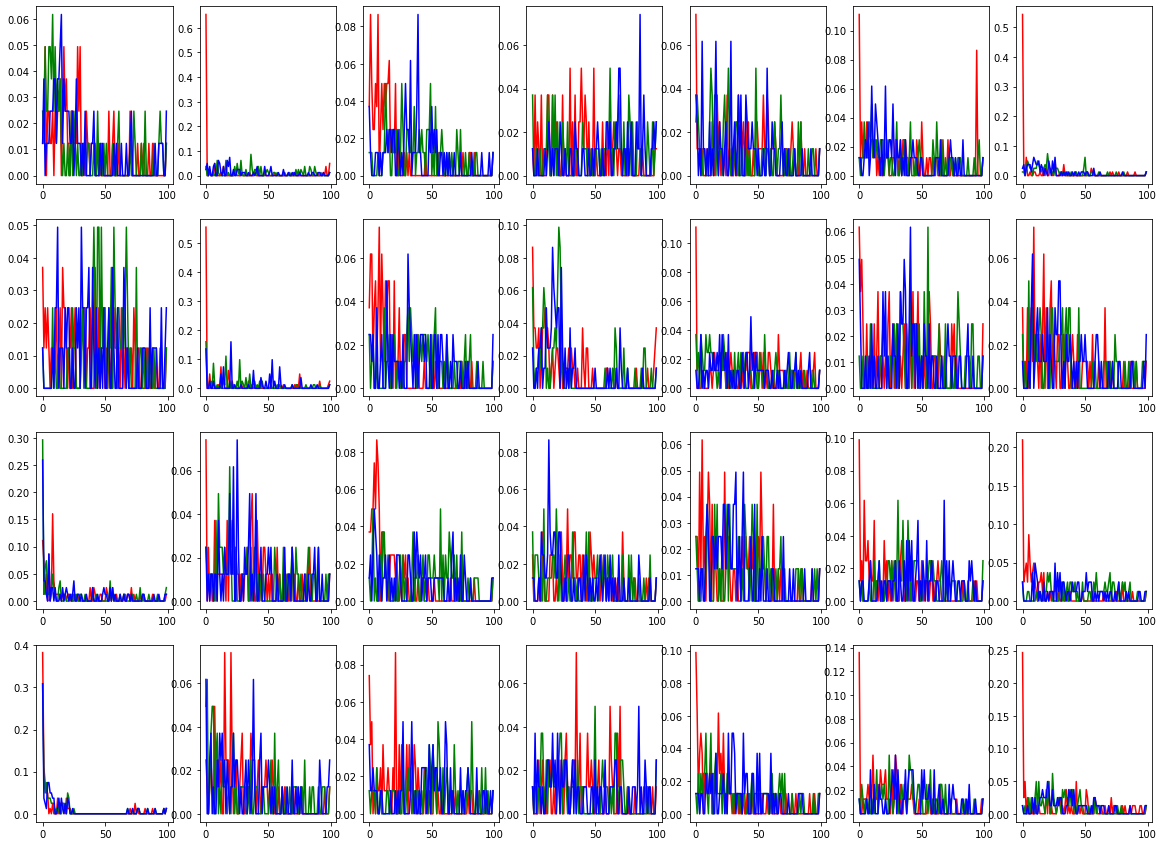

In [21]:
bad_mag = sobel(bad_kpt_patches.view((N*T*K, C, Hp, Wp))).view((N, T, K, C, Hp, Wp))

bad_mag_hists = torch.empty((N, T, K, C, n_bins))

for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                bad_mag_hists[n, t, k, c] = torch.histc(bad_mag[n, t, k, c], bins=n_bins)
                bad_mag_hists[n, t, k, c] /= torch.sum(bad_mag_hists[n, t, k, c], dim=-1)
                
fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), bad_mag_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), bad_mag_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), bad_mag_hists[0, t, k, 2], color='blue')

tensor([[0.0494, 0.1605, 0.0864, 0.0988, 0.0617, 0.0864, 0.5062],
        [0.2840, 0.4815, 0.0741, 0.0988, 0.0864, 0.0617, 0.1728],
        [0.2716, 0.0617, 0.0741, 0.0617, 0.0741, 0.0617, 0.0864]])
tensor(0.1429)


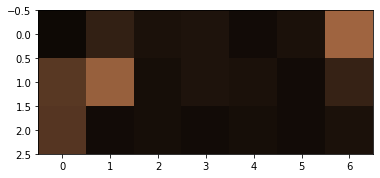

In [22]:
bad_mag_dist = torch.empty((K, T-1))

for k in range(K):
    for t in range(T-1):
        #perfect_dist[k, t] = dkl(perfect_hists[0, t:t+1, k, :], perfect_hists[0, t+1:t+2, k, :])
        bad_mag_dist[k, t] = torch.norm(bad_mag_hists[0, t:t+1, k, :] - bad_mag_hists[0, t+1:t+2, k, :], p=hist_norm_p)

print(bad_mag_dist.T)

plt.imshow(bad_mag_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(bad_mag_dist.mean())

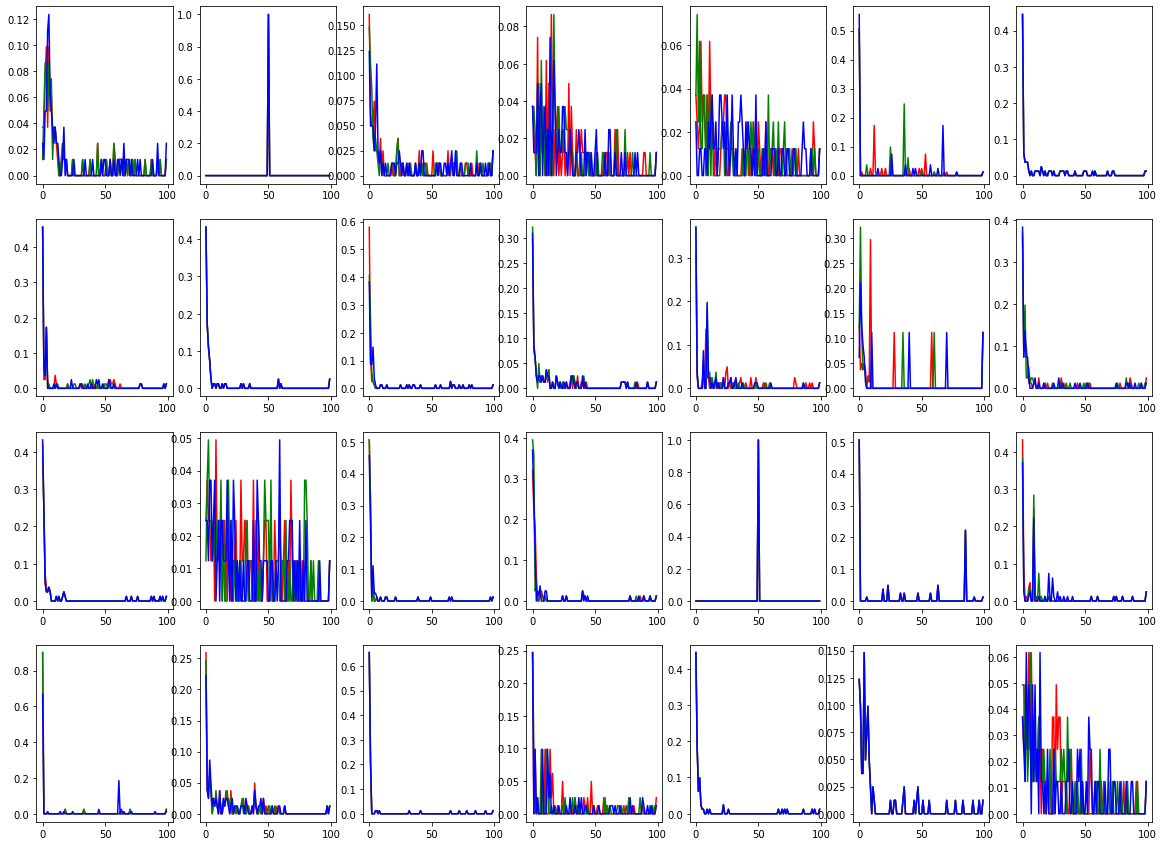

In [23]:
random_mag = sobel(random_kpt_patches.view((N*T*K, C, Hp, Wp))).view((N, T, K, C, Hp, Wp))

random_mag_hists = torch.empty((N, T, K, C, n_bins))

for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                random_mag_hists[n, t, k, c] = torch.histc(random_mag[n, t, k, c], bins=n_bins)
                random_mag_hists[n, t, k, c] /= torch.sum(random_mag_hists[n, t, k, c], dim=-1)
                
fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), random_mag_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), random_mag_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), random_mag_hists[0, t, k, 2], color='blue')

tensor([[0.4444, 1.0000, 0.4198, 0.2840, 0.3457, 0.4938, 0.1605],
        [0.2222, 0.4198, 0.1975, 0.2840, 1.0000, 0.4444, 0.2716],
        [0.5185, 0.2346, 0.1975, 0.2593, 1.0000, 0.3827, 0.3951]])
tensor(0.4274)


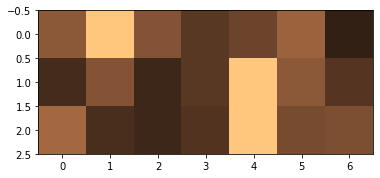

In [24]:
random_mag_dist = torch.empty((K, T-1))

for k in range(K):
    for t in range(T-1):
        #perfect_dist[k, t] = dkl(perfect_hists[0, t:t+1, k, :], perfect_hists[0, t+1:t+2, k, :])
        random_mag_dist[k, t] = torch.norm(random_mag_hists[0, t:t+1, k, :] - random_mag_hists[0, t+1:t+2, k, :], p=hist_norm_p)

print(random_mag_dist.T)
        
plt.imshow(random_mag_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(random_mag_dist.mean())